In [1]:
from circuit.utils import make_circuitlet
from generate_dataset import gen_cut_dataset
from sklearn.model_selection import train_test_split
from collections import defaultdict
import copy
import random
import numpy as np

from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle

In [2]:
size = 6
n_qubits = 18


topology = gen_grid_topology(size)  # 3x3 9 qubits
new_topology = defaultdict(list)
for qubit in topology.keys():
    if qubit < n_qubits:
        for ele in topology[qubit]:
            if ele < n_qubits:
                new_topology[qubit].append(ele)
topology = new_topology
neighbor_info = copy.deepcopy(topology)
coupling_map = topology_to_coupling_map(topology)


backend = Backend(n_qubits=n_qubits, topology=topology, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)


In [3]:

step_datasets, step_models = [],[]

erroneous_pattern = None 
for n_steps  in range(4):
    dataset = gen_cut_dataset(n_qubits, topology, neighbor_info, coupling_map, dataset_size = 5000,min_cut_qubit=3,devide_size=5)

    test_dataset = gen_cut_dataset(n_qubits, topology, neighbor_info, coupling_map, dataset_size = 1000,min_cut_qubit=3,devide_size=5)


    print('train dataset size = ', len(dataset))
    print('test dataset size = ', len(test_dataset))
    
    
    upstream_model = RandomwalkModel(
        n_steps, 20, backend=backend, travel_directions=('parallel', 'former'))
    
    upstream_model.train(dataset + test_dataset, multi_process=True,
                         remove_redundancy=n_steps > 1)

    dataset_cut = make_circuitlet(dataset)
    print("cutted", len(dataset_cut))
    
    test_dataset_cut = make_circuitlet(test_dataset)
    print("cutted", len(test_dataset_cut))
    
    all_to_all_backend = Backend(n_qubits=5, topology=None, neighbor_info=neighbor_info, basis_single_gates=default_basis_single_gates,
                  basis_two_gates=default_basis_two_gates, divide=False, decoupling=False)
            
    simulator = NoiseSimulator(all_to_all_backend)

    
    # 每个subcircuit是单独的NoiseSimulator，backend对应不对
    if erroneous_pattern is None:
        erroneous_pattern = simulator.get_error_results(
            dataset_cut + test_dataset_cut, upstream_model, multi_process=True, erroneous_pattern=erroneous_pattern)
    upstream_model.erroneous_pattern = erroneous_pattern

    with open(f"upstream_model_step{n_steps}.pkl", "wb")as f:
        pickle.dump(upstream_model, f)

    train_dataset, validation_dataset = train_test_split(dataset_cut, test_size = .2)
    
    test_dataset = np.array(test_dataset_cut)

    step_datasets.append((train_dataset, validation_dataset, test_dataset))
    step_models.append(upstream_model)
    with open(f"dataset_step{n_steps}.pkl", "wb")as f:
        pickle.dump((train_dataset, validation_dataset, test_dataset), f)




[[2, 3, 4, 5, 10], [0, 1, 6, 7, 12], [9, 11, 15, 16, 17], [8, 13, 14]]
[[4, 5, 10, 11, 17], [2, 8, 13, 14, 15], [0, 1, 6, 7, 12]]
[[1, 2, 3, 4, 9], [0, 6, 7, 8, 12], [5, 10, 11, 16, 17], [13, 14, 15]]
[[0, 1, 2, 6, 12], [7, 8, 13, 14, 15], [5, 10, 11, 16, 17], [3, 4, 9]]
[[0, 6, 7, 8, 12], [2, 3, 9, 10, 15], [4, 5, 11, 16, 17]]
[[0, 1, 2, 6, 12], [3, 4, 5, 8, 9], [7, 13, 14, 15, 16], [10, 11, 17]]
[[0, 1, 2, 3, 8], [6, 7, 12, 13, 14], [4, 5, 10, 11, 17], [9, 15, 16]]


2023-07-31 13:33:46,284	INFO worker.py:1621 -- Started a local Ray instance.
Exception ignored in: <function _xla_gc_callback at 0x0000023DFFC47C70>
Traceback (most recent call last):
  File "C:\ProgramData\miniconda3\envs\QuCT-Micro2023\lib\site-packages\jax\_src\lib\__init__.py", line 104, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


4620 circuit generated
[[0, 1, 2, 6, 12], [3, 4, 5, 8, 9], [7, 13, 14, 15, 16], [10, 11, 17]]
[[5, 10, 11, 16, 17], [0, 1, 2, 3, 8], [6, 7, 12, 13, 14]]
[[3, 9, 14, 15, 16], [0, 1, 2, 6, 12], [4, 5, 10, 11, 17], [7, 8, 13]]
[[3, 8, 9, 10, 15], [0, 6, 12, 13, 14], [1, 2, 7], [4, 5, 11, 16, 17]]
[[2, 3, 4, 5, 10], [1, 7, 8, 9, 14], [11, 15, 16, 17], [0, 6, 12, 13]]
900 circuit generated
train dataset size =  4620
test dataset size =  900
(remote_train pid=23088) train:0/552, 0th offest
(remote_train pid=18900) train:100/552, 4968th offest [repeated 50x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
count path
random walk finish device size =  45
0 path table size =  3
1 path table size =  3
2 path table size =  3
3 path table size =  3
4 path table size =  3
5 path table size =  3
6 path table size =  3
7 path table size =  3


Exception ignored in: Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "C:\ProgramData\miniconda3\envs\QuCT-Micro2023\lib\site-packages\ipykernel\iostream.py", line 648, in write
    self._schedule_flush()
  File "C:\ProgramData\miniconda3\envs\QuCT-Micro2023\lib\site-packages\ipykernel\iostream.py", line 545, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "C:\ProgramData\miniconda3\envs\QuCT-Micro2023\lib\site-packages\ipykernel\iostream.py", line 251, in schedule
    self._event_pipe.send(b"")
  File "C:\ProgramData\miniconda3\envs\QuCT-Micro2023\lib\site-packages\zmq\sugar\socket.py", line 696, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "zmq\backend\cython\socket.pyx", line 742, in zmq.backend.cython.socket.Socket.send
  File "zmq\backend\cython\socket.pyx", line 789, in zmq.backend.cython.socket.Socket.send
  File "zmq\backend\cython\socket.pyx", 

In [4]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
def plot_scaater(reals, predicts, durations ,name):
    par = np.polyfit(reals, predicts, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    x1 = [0.4, 1.0]
    y1 = [slope*xx + intercept  for xx in x1]
    #定义颜色
    colors = ["#FF3636", '#277C8E' ,"#1F77B4"]
    '''xia <- shang'''
    # colors.reverse()
    # colors = np.array(colors) / 256
    # 定义颜色的位置
    pos = [0, .5, 1]
    # 创建colormap对象
    cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

    normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

    # cmap_name = 'Blues'
    # cmap_name = 'viridis'
    # cmap_name = 'plasma'
    # cmap_name = 'winter'

    random_index = list(range(len(reals)))
    random.shuffle(random_index)
    random_index = random_index[:1500]
    reals = np.array(reals)
    predicts = np.array(predicts)
    fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
    axes.axis([0, 1, 0, 1])
    axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=80 )
    axes.plot(x1,y1)
    axes.set_xlim(.4, 1)
    axes.set_ylim(.4, 1)
    axes.set_xlabel('real ')
    axes.set_ylabel('predict')
    axes.plot([[0,0],[1,1]])
    # fig.colorbar(cm.ScalarMappable( cmap=cmap))
    fig.savefig(name)
    print(slope, intercept)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


n_instruction2circuit_infos =  {70: 176, 140: 170, 90: 175, 80: 170, 60: 179, 120: 169, 30: 176, 50: 175, 160: 167, 40: 179, 100: 163, 110: 172, 20: 173, 150: 182, 130: 166}
epoch: 0, 	 epoch loss = 13335.26953125, 	 test loss = 1908.31982421875
epoch: 1, 	 epoch loss = 11381.4140625, 	 test loss = 1634.139892578125
epoch: 2, 	 epoch loss = 9813.8310546875, 	 test loss = 1408.57666015625
epoch: 3, 	 epoch loss = 8511.2041015625, 	 test loss = 1222.543212890625
epoch: 4, 	 epoch loss = 7444.974609375, 	 test loss = 1060.3583984375
epoch: 5, 	 epoch loss = 6524.07568359375, 	 test loss = 938.7359008789062
epoch: 6, 	 epoch loss = 5789.77685546875, 	 test loss = 821.9151000976562
epoch: 7, 	 epoch loss = 5152.41357421875, 	 test loss = 733.9157104492188
epoch: 8, 	 epoch loss = 4635.25146484375, 	 test loss = 656.863037109375
epoch: 9, 	 epoch loss = 4196.61962890625, 	 test loss = 596.1800537109375
epoch: 10, 	 epoch loss = 3839.2080078125, 	 test loss = 542.4006958007812
epoch: 11, 	 ep

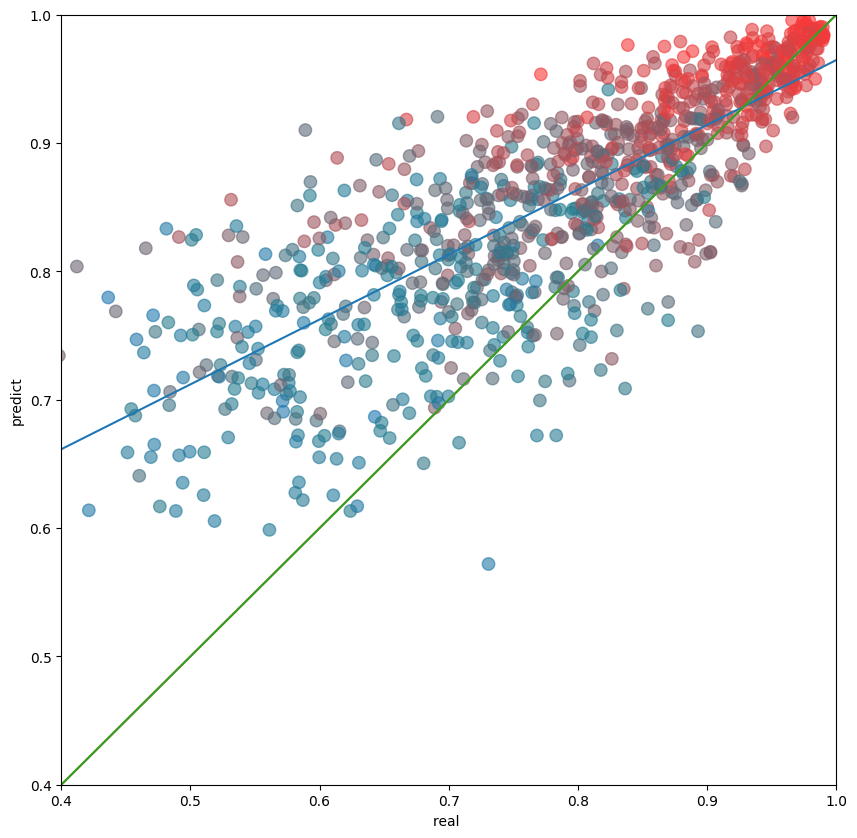

In [5]:

for step, step_dataset in enumerate(step_datasets):
    train_dataset, validation_dataset, test_dataset = step_dataset
    upstream_model  = step_models[step]
    
    downstream_model = FidelityModel(upstream_model)
    downstream_model.train(
        train_dataset, validation_dataset, epoch_num=200,)

    predicts, reals, durations = [], [], []
    for idx, cir in enumerate(test_dataset):
        cir = upstream_model.vectorize(cir)
        if idx % 100 == 0:
            print(idx, "predict finished!")
        predict = downstream_model.predict_fidelity(cir)

        predicts.append(predict)
        reals.append(cir['ground_truth_fidelity'])
        durations.append(cir['duration'])

    reals = np.array(reals)
    predicts = np.array(predicts)
    durations = np.array(durations)

    plot_scaater(reals, predicts, durations, name = f'scatter_step{step}.png')

    #     # print(predict)
    with open(f"error_params_predicts_step{step}.pkl", "wb")as f:
        pickle.dump((downstream_model, predicts, reals, durations, test_dataset), f)

        
    print('average inaccuracy = ', np.abs(predicts - reals).mean())

In [6]:
step = 2
with open(f"error_params_predicts_step{step}.pkl","rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)
    


In [7]:
from upstream.randomwalk_model import extract_device
def get_baseline_predict(circuit_info, single_average_error, couple_average_error):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [8]:
rb_single_average_error = {0: 0.9994094148043156, # rb
 1: 0.9993508083886652,
 2: 0.9993513578387458,
 3: 0.9996978330672296,
 4: 0.9997258463524775,
 5: 0.9993898065578337,
 6: 0.9998335484697743,
 7: 0.9997460044815009,
 8: 0.9997219426985601,
 9: 0.9992924485427597,
 10: 0.9994018918682177,
 11: 0.9998410411794697,
 12: 0.9994231683912435,
 13: 0.9995938422219371,
 14: 0.9947661045069707,
 15: 0.9997576786354693,
 16: 0.9998387638441334,
 17: 0.9996691783504945}
rb_couple_average_error = {(5,11): 0.993651602350742, # rb
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}

0.8095247297964852 0.10067431416573665


(-0.048135539984302506, 0.13722559048780436)

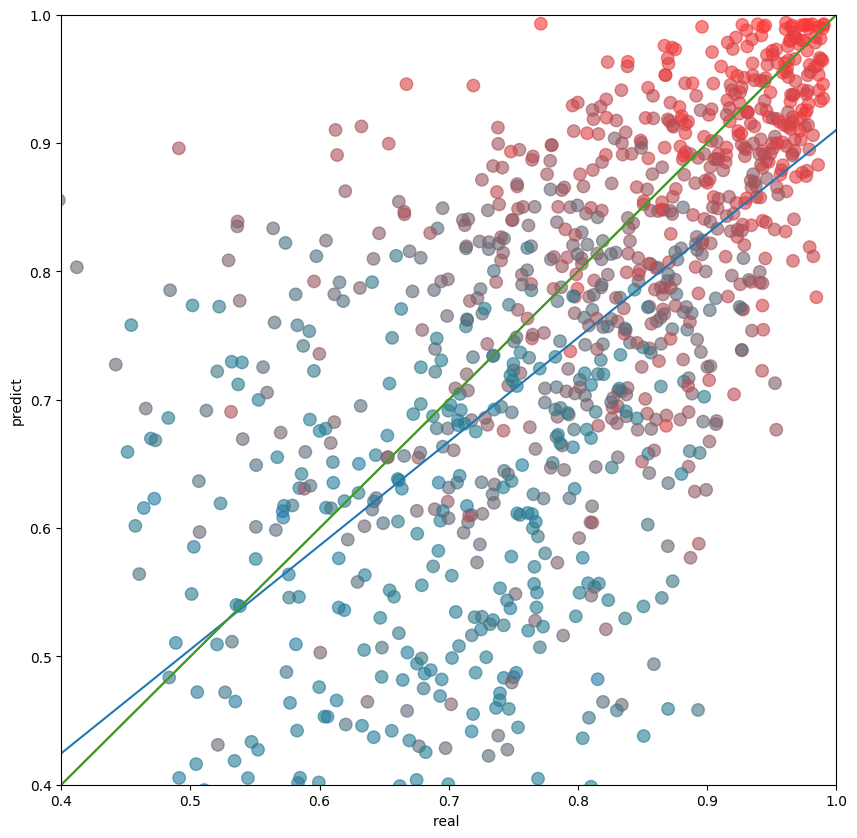

In [9]:
rbs = []
for cir in test_dataset:
    rbs.append(get_baseline_predict(cir, rb_single_average_error, rb_couple_average_error))
rbs = np.array(rbs)
plot_scaater(reals, rbs, durations, name = f'scatter_rb.png')
(rbs-reals).mean(), (rbs-reals).std()


In [10]:
xeb_single_average_error = {0: 0.9994, #xeb
 1: 0.99956,
 2: 0.99918,
 3: 0.99976,
 4: 0.9994,
 5: 0.99962,
 6: 0.99989,
 7: 0.99973,
 8: 0.99961,
 9: 0.99941,
 10: 0.99975,
 11: 0.99939,
 12: 0.99873,
 13: 0.9996,
 14: 0.99946,
 15: 0.99976,
 16: 0.99977,
 17: 0.99975}
xeb_couple_average_error = {(5, 11): 0.98602, # xeb
 (11, 17): 0.99561,
 (4, 5): 0.99482,
 (10, 11): 0.99529,
 (16, 17): 0.996,
 (4, 10): 0.9908,
 (10, 16): 0.99501,
 (3, 4): 0.99738,
 (9, 10): 0.99373,
 (15, 16): 0.9934499999999999,
 (3, 9): 0.99659,
 (9, 15): 0.99357,
 (2, 3): 0.99353,
 (8, 9): 0.98778,
 (14, 15): 0.9956,
 (2, 8): 0.98862,
 (8, 14): 0.99711,
 (1, 2): 0.99445,
 (7, 8): 0.97725,
 (13, 14): 0.99527,
 (1, 7): 0.99098,
 (7, 13): 0.99424,
 (0, 1): 0.99394,
 (6, 7): 0.99452,
 (12, 13): 0.99141,
 (0, 6): 0.99474,
 (6, 12): 0.99312}

0.42281790939068936 0.5105679035771807


(0.05964121566742896, 0.11365483700063851)

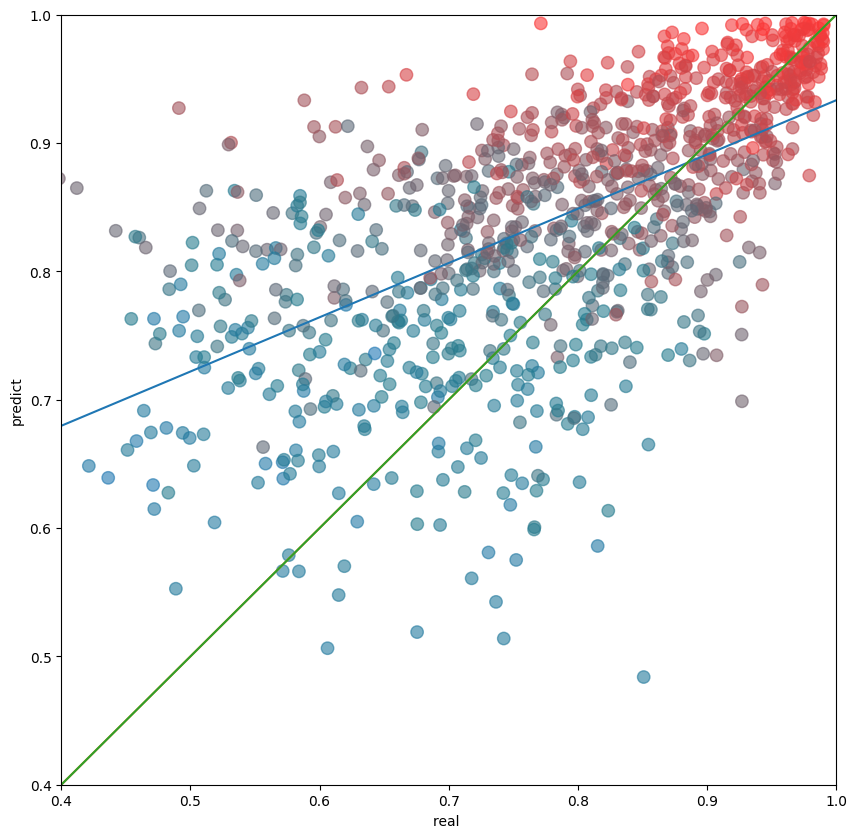

In [11]:
xebs = []
for cir in test_dataset:
    xebs.append(get_baseline_predict(cir, xeb_single_average_error, xeb_couple_average_error))
xebs = np.array(xebs)
plot_scaater(reals, xebs, durations, name = f'scatter_xeb.png')
(xebs-reals).mean(), (xebs-reals).std()


[0.02646531456992739, 0.037961259286546346, 0.048557942377435236, 0.07493597707672725, 0.08418229782148555, 0.08942500270657872, 0.11003481703034242, 0.11625674355423059, 0.09980324581162416] [0.033949668571467896, 0.046078938696603754, 0.056936363762139494, 0.08895095571447624, 0.08761367156460922, 0.11738637743486238, 0.12472447219159481, 0.12945751826289148, 0.10440879608415651] [0.035868941962526796, 0.06084354181193964, 0.07495860486377727, 0.09415337927906695, 0.09900580692195582, 0.12856874479692834, 0.11585129494966924, 0.1555902446333861, 0.14099861434330396]


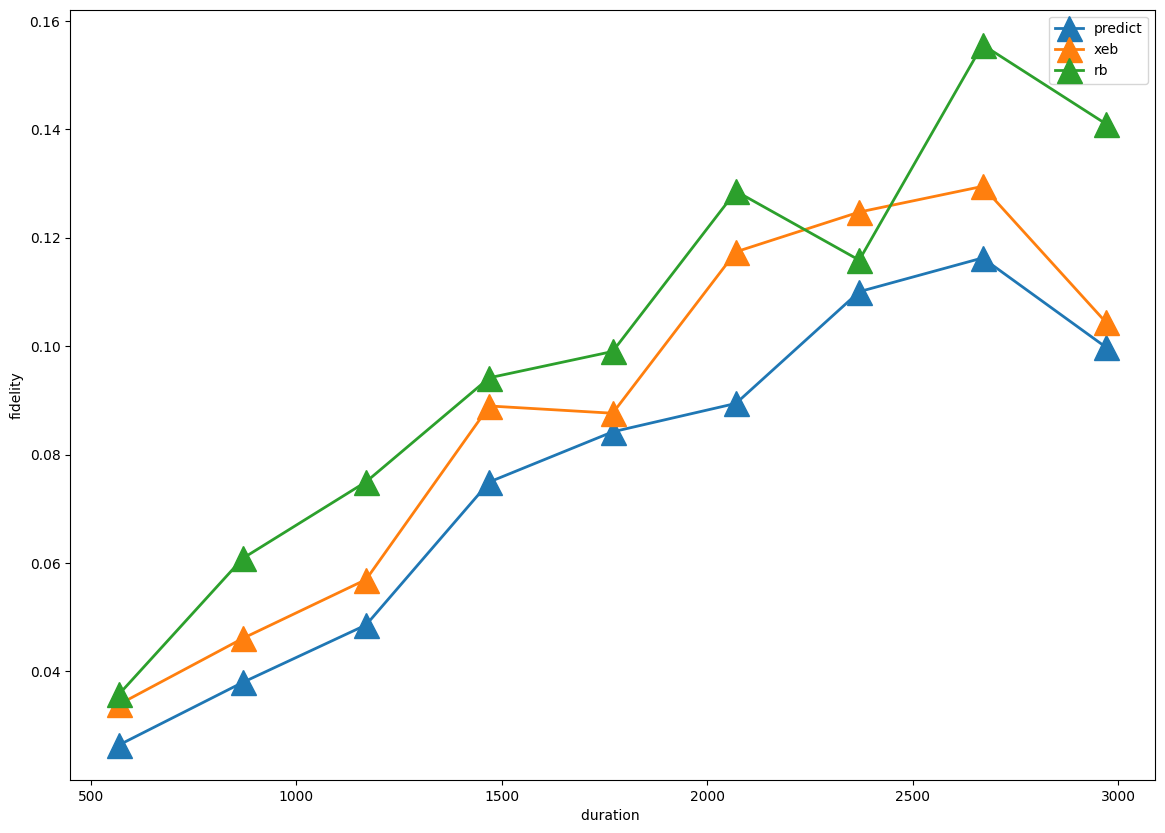

In [13]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).mean())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).mean())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).mean())
    


 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"delta_fidelity_duration.svg")  # step
